#1. Implementing Word2Vec
In this part you will implement the word2vec model and train your own word vectors with stochastic gradient descent (SGD). Numpy methods could be utilized to make your code both shorter and faster. 
The following requirements should be satisfied:  
- a) Negative sampling loss
- b) Implement the skip-gram model from scratch
- c) Train with real-data
- d) Show the resulting embeddings

Skipgram

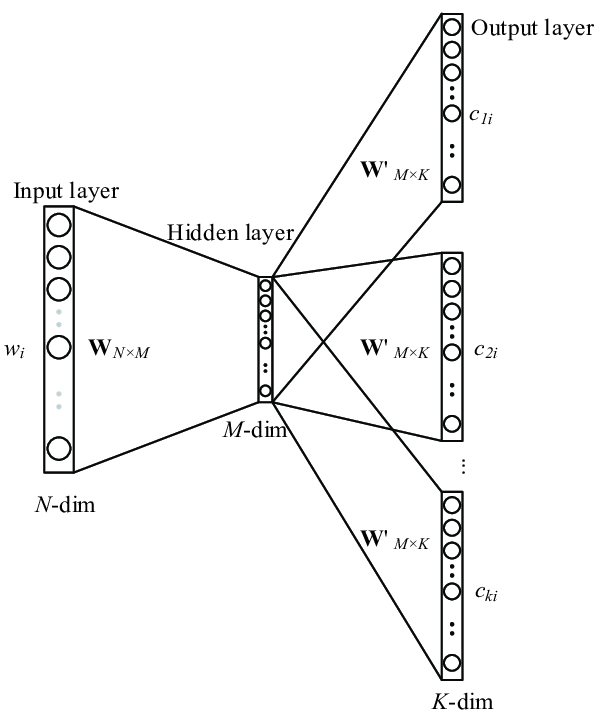

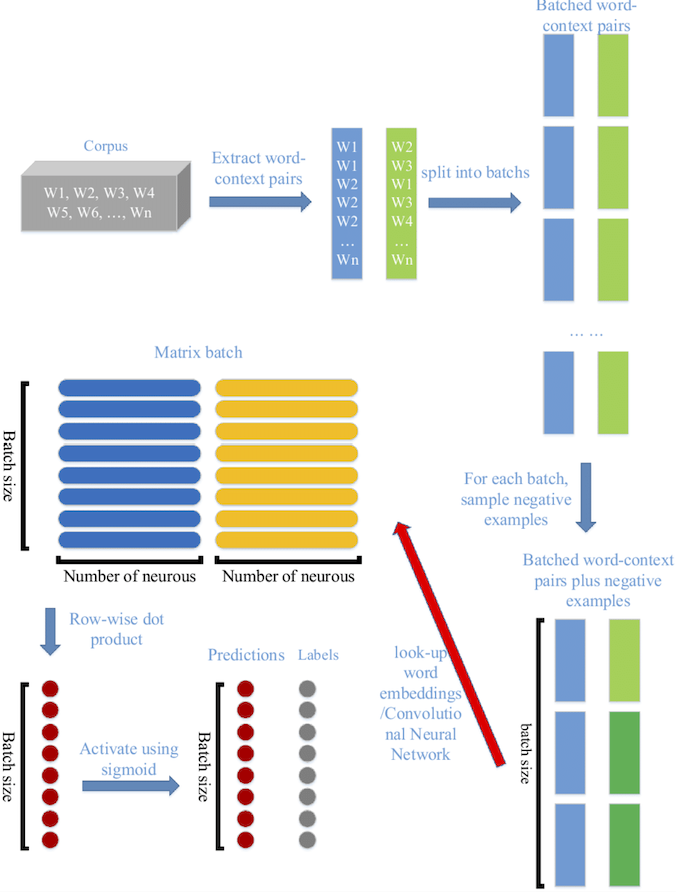

    # Positive sample
    skip_grams.append([input_word, context_word[0], 1])  # context_word[0] is the positive context word
    skip_grams.append([input_word, context_word[1], 1])  # context_word[1] is the positive context word

    # Negative samples
    for _ in range(num_negative_samples):
        negative_word = np.random.randint(voc_size)
        skip_grams.append([input_word, negative_word, 0])  # 0 indicates a negative sample

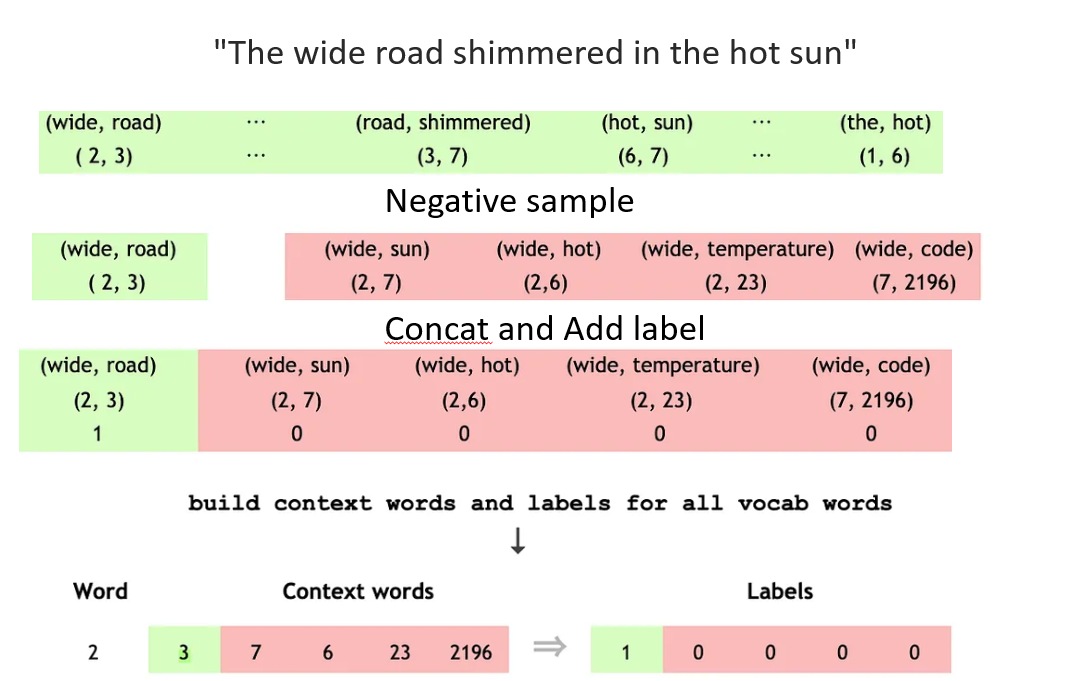

In [1]:
import io
import re
import string
import tqdm

import numpy as np

import tensorflow as tf
from tensorflow.keras import layers

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

dtype = torch.FloatTensor
# Load the TensorBoard notebook extension
%load_ext tensorboard
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE

This code snippet is an implementation of the Word2Vec algorithm for training word embeddings. Let's go through the code and explain each step:

1.Reading and Preprocessing the Text:

- The code reads the text from a file named "book1.txt" 
and stores it in the text variable.
- The text is converted to lowercase using text.lower().
- Punctuation is removed from the text using the regular expression re.sub("([^a-zA-Z\s])", "", text).
- Remove unnecessary white spaces
- The preprocessed text is split into sentences and then into individual words.
- The vocabulary is constructed by creating a set of unique words in the text and assigning each word a unique index using a dictionary.








In [2]:
#The code reads the text from a file named "book1.txt" 
import re
with open("book1.txt", "r") as file:
    text = file.read()

In [3]:
text = text.lower()  # Convert to lowercase
text = re.sub("([^a-zA-Z\s])", "", text)  # Remove punctuation
sentences = text.split("\n")
word_sequence = " ".join(sentences).split()
word_sequence = [word.strip() for word in word_sequence if word.strip()]  # Remove unnecessary white spaces

# The vocabulary is constructed by creating a set of unique words in the text and assigning each word a unique index using a dictionary.
word_list = list(set(word_sequence))
word_dict = {w: i for i, w in enumerate(word_list)}
 
print(word_dict)

{'secretary': 0, 'broad': 1, 'its': 2, 'one': 3, 'heart': 4, 'rooted': 5, 'sleeping': 6, 'window': 7, 'jk': 8, 'by': 9, 'explain': 10, 'heard': 11, 'and': 12, 'so': 13, 'would': 14, 'trying': 15, 'ask': 16, 'story': 17, 'stupid': 18, 'important': 19, 'know': 20, 'hadnt': 21, 'starts': 22, 'emeraldgreen': 23, 'never': 24, 'sitting': 25, 'realize': 26, 'last': 27, 'weather': 28, 'look': 29, 'moved': 30, 'shouted': 31, 'several': 32, 'too': 33, 'up': 34, 'stared': 35, 'neck': 36, 'his': 37, 'cloak': 38, 'country': 39, 'act': 40, 'since': 41, 'oddly': 42, 'dundee': 43, 'fell': 44, 'angry': 45, 'drove': 46, 'though': 47, 'angrily': 48, 'loudly': 49, 'day': 50, 'happily': 51, 'cat': 52, 'tried': 53, 'sipped': 54, 'happening': 55, 'five': 56, 'funny': 57, 'hundreds': 58, 'can': 59, 'head': 60, 'stumbled': 61, 'oh': 62, 'came': 63, 'gossiped': 64, 'tiny': 65, 'to': 66, 'do': 67, 'decided': 68, 'wide': 69, 'jam': 70, 'now': 71, 'corner': 72, 'stare': 73, 'sinking': 74, 'across': 75, 'petunia': 

2.The code sets the parameters for the Word2Vec model, including the batch size, embedding size, and vocabulary size.
Generating Skip-grams:

In [4]:
# Word2Vec Parameter
batch_size = 20
embedding_size = 2
voc_size = len(word_list)

3.Skip-grams are generated from the word sequence.
- skip-gram consists of an input word and its context words.
- For each word in the sequence (except the first and last word), positive skip-grams are created by pairing the word with its previous and next words.
- Negative samples are randomly selected by pairing the input word with randomly chosen non-context words.
- The skip-grams are stored in the skip_grams list.

In [ ]:
num_negative_samples = 5  # Number of negative samples per positive sample ( around 10% from 662) initial use = 5 
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    input_word = word_dict[word_sequence[i]]
    context_word = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    # Positive sample
    skip_grams.append([input_word, context_word[0], 1])  # context_word[0] is the positive context word
    skip_grams.append([input_word, context_word[1], 1])  # context_word[1] is the positive context word

    # Negative samples
    #Negative samples are randomly selected by pairing the input word with randomly chosen non-context words.
    for _ in range(num_negative_samples):
        negative_word = np.random.randint(voc_size)
        skip_grams.append([input_word, negative_word, 0])  # 0 indicates a negative sample

4.Word2Vec Model Definition:
- The Word2Vec class is defined to represent the Word2Vec model.
- The class has an initialization method that takes the vocabulary size and embedding size as parameters.
- The model parameters W and V are initialized with random values.

In [ ]:
class Word2Vec:
    def __init__(self, voc_size, embedding_size):
        self.voc_size = voc_size
        self.embedding_size = embedding_size
        self.W = np.random.uniform(-1.0, 1.0, (self.voc_size, self.embedding_size))
        self.V = np.random.uniform(-1.0, 1.0, (self.embedding_size, self.voc_size))

    def forward(self, X):
        hidden_layer = np.matmul(X, self.W)  # hidden_layer: [batch_size, embedding_size]
        output_layer = 1 / (1 + np.exp(-np.matmul(hidden_layer, self.V)))  # output_layer: [batch_size, voc_size]
        return output_layer

5.Training the Word2Vec Model:

- The training loop starts, iterating over a specified number of epochs.
- In each epoch, a batch of skip-grams is randomly selected.
- The input word of each skip-gram is one-hot encoded, and the batch inputs and labels are constructed.
The forward pass is performed by multiplying the batch inputs with the input-to-hidden layer weights (W) and applying the sigmoid function to get the output probabilities.
- The sigmoid cross-entropy loss is calculated based on the output probabilities and the labels.
Backpropagation is performed to compute the gradients of the weights.


 sigmoid_output = 1 / (1 + np.exp(-output))

In this calculation, sigmoid_output represents the output of the model after applying the sigmoid function, and labels represent the target labels (1 for positive samples, 0 for negative samples). The loss function is computed using the binary cross-entropy formula.

- The weights of the model are updated using gradient descent.


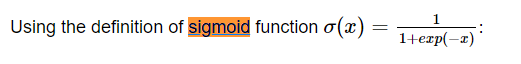

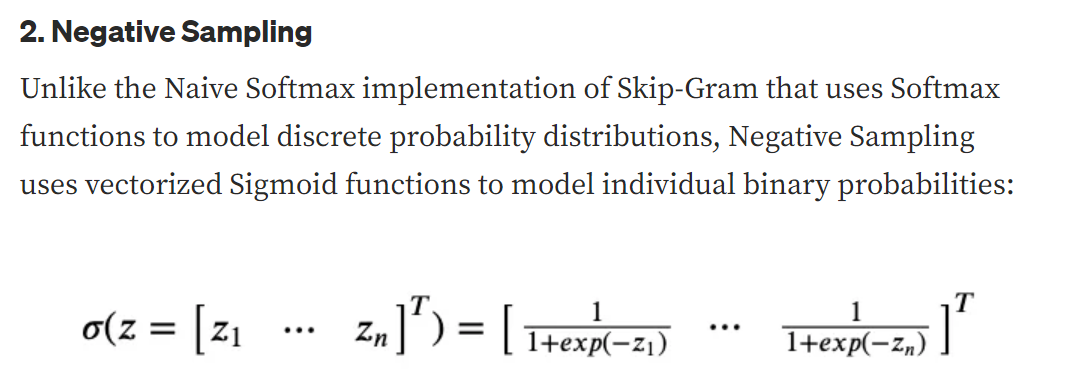

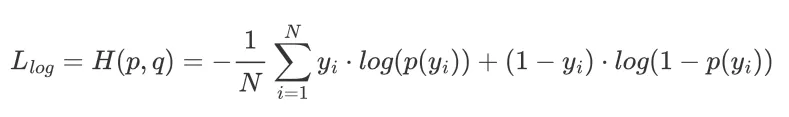

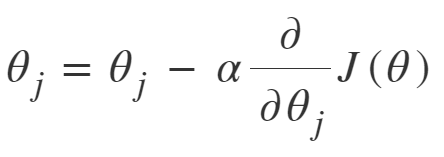

: The negative samples contribute to the loss through the term np.log(1 - sigmoid_output) * (1 - labels), as we want to minimize the similarity between the input word and the negative context words. The positive samples contribute to the loss through the term np.log(sigmoid_output) * labels, as we want to maximize the similarity between the input word and the positive context word.

np.log(sigmoid_output) * labels computes the element-wise multiplication between the logarithm of the sigmoid output and the labels. This term corresponds to the positive samples in the training examples.

np.log(1 - sigmoid_output) * (1 - labels) computes the element-wise multiplication between the logarithm of the complement of the sigmoid output and the complement of the labels. This term corresponds to the negative samples in the training examples.

The gradients d_W and d_V are computed using matrix multiplication as follows:

d_W = np.matmul(batch_inputs.T, d_hidden)

Here, batch_inputs is the input word matrix, where each row represents a one-hot encoded vector for an input word in the batch. batch_inputs.T is the transpose of the input word matrix. d_hidden is the gradient of the hidden layer with respect to the output layer. The matrix multiplication calculates the dot product between the transpose of the input word matrix and the gradient of the hidden layer, resulting in the gradient of the objective function with respect to the weight matrix W.

d_V = np.matmul(d_hidden.T, d_output)

Similarly, d_hidden.T is the transpose of the gradient of the hidden layer, and d_output is the gradient of the output layer. The matrix multiplication calculates the dot product between the transpose of the gradient of the hidden layer and the gradient of the output layer, resulting in the gradient of the objective function with respect to the weight matrix V.

In [ ]:
# Training
word2vec = Word2Vec(voc_size, embedding_size)
learning_rate = 0.001

loss_values = []  # List to store the loss values
epochs = []  # List to store the epoch numbers
smoothing_factor = 0.8  # Smoothing factor for the moving average filter

for epoch in range(15000):
    batch_inputs = []
    batch_labels = []
    batch_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for i in batch_index:
        input_word = np.eye(voc_size)[skip_grams[i][0]]  # one-hot encoding of input word
        batch_inputs.append(input_word)
        batch_labels.append(skip_grams[i][1])

    batch_inputs = np.array(batch_inputs)
    batch_labels = np.array(batch_labels)
    labels = np.array([skip_grams[i][2] for i in batch_index])  # 1 for positive samples, 0 for negative samples

    output = word2vec.forward(batch_inputs)
    

    # Sigmoid Cross-entropy loss
    loss = -np.mean(labels.reshape(-1, 1) * np.log(output) + (1 - labels.reshape(-1, 1)) * np.log(1 - output))

    if (epoch + 1) % 1000 == 0:
        print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    # Backpropagation
    #Calculate the gradient of the output layer:
    d_output = (output - labels.reshape(-1, 1)) / batch_size # (y^-y)
    #Backpropagate the gradients to the hidden layer:
    d_hidden = np.matmul(d_output, word2vec.V.T)
    #Compute the gradients for the weights of the input-to-hidden layer:
    d_W = np.matmul(batch_inputs.T, d_hidden)
    #Compute the gradients for the weights of the hidden-to-output layer:
    d_V = np.matmul(d_hidden.T, d_output)

    # Update the weights of the model using gradient descent:
    word2vec.W -= learning_rate * d_W
    word2vec.V -= learning_rate * d_V

    loss_values.append(loss)  # Append the loss value to the list
    epochs.append(epoch + 1)  # Append the epoch number to the list

# Apply moving average filter for smoothing
smoothed_loss_values = [loss_values[0]]
for i in range(1, len(loss_values)):
    smoothed_loss_values.append(smoothing_factor * smoothed_loss_values[i-1] + (1 - smoothing_factor) * loss_values[i])

# Learned W
W = word2vec.W
print(W)

Epoch: 1000 cost = 0.709965
Epoch: 2000 cost = 0.700343
Epoch: 3000 cost = 0.698137
Epoch: 4000 cost = 0.696407
Epoch: 5000 cost = 0.698514
Epoch: 6000 cost = 0.698874
Epoch: 7000 cost = 0.697909
Epoch: 8000 cost = 0.696336
Epoch: 9000 cost = 0.696056
Epoch: 10000 cost = 0.696632
Epoch: 11000 cost = 0.695530
Epoch: 12000 cost = 0.695291
Epoch: 13000 cost = 0.696599
Epoch: 14000 cost = 0.695119
Epoch: 15000 cost = 0.694251
[[-0.15229531 -0.57849698]
 [-0.68585555 -0.78385932]
 [-0.78721824 -0.07629392]
 ...
 [ 0.33527206 -0.01036777]
 [-0.42117513 -0.73308234]
 [ 0.23139243 -0.00897566]]


6.Learned Word Embeddings:
- The learned weights W of the Word2Vec model represent the word embeddings.
- The variable W contains the learned word embeddings.

In [ ]:
# Learned W
W = word2vec.W
print(W)

[[-0.15229531 -0.57849698]
 [-0.68585555 -0.78385932]
 [-0.78721824 -0.07629392]
 ...
 [ 0.33527206 -0.01036777]
 [-0.42117513 -0.73308234]
 [ 0.23139243 -0.00897566]]


In [ ]:
print(word_dict)

{'good': 0, 'nice': 1, 'stretch': 2, 'explain': 3, 'why': 4, 'angrily': 5, 'never': 6, 'keeping': 7, 'everywhere': 8, 'promise': 9, 'trying': 10, 'something': 11, 'overhead': 12, 'calls': 13, 'trick': 14, 'seem': 15, 'his': 16, 'could': 17, 'director': 18, 'right': 19, 'dared': 20, 'cups': 21, 'expected': 22, 'hummed': 23, 'nephew': 24, 'first': 25, 'enraged': 26, 'man': 27, 'the': 28, 'couldnt': 29, 'shocked': 30, 'very': 31, 'nighttime': 32, 'havent': 33, 'room': 34, 'country': 35, 'yelled': 36, 'finer': 37, 'same': 38, 'up': 39, 'five': 40, 'obviously': 41, 'bunch': 42, 'still': 43, 'weatherman': 44, 'excitedly': 45, 'made': 46, 'together': 47, 'no': 48, 'you': 49, 'middle': 50, 'happily': 51, 'twice': 52, 'over': 53, 'an': 54, 'however': 55, 'determined': 56, 'knocked': 57, 'afternoon': 58, 'eight': 59, 'dashed': 60, 'mixing': 61, 'wife': 62, 'doors': 63, 'day': 64, 'maps': 65, 'look': 66, 'throwing': 67, 'crept': 68, 'wet': 69, 'they': 70, 'much': 71, 'sight': 72, 'gray': 73, 'aro

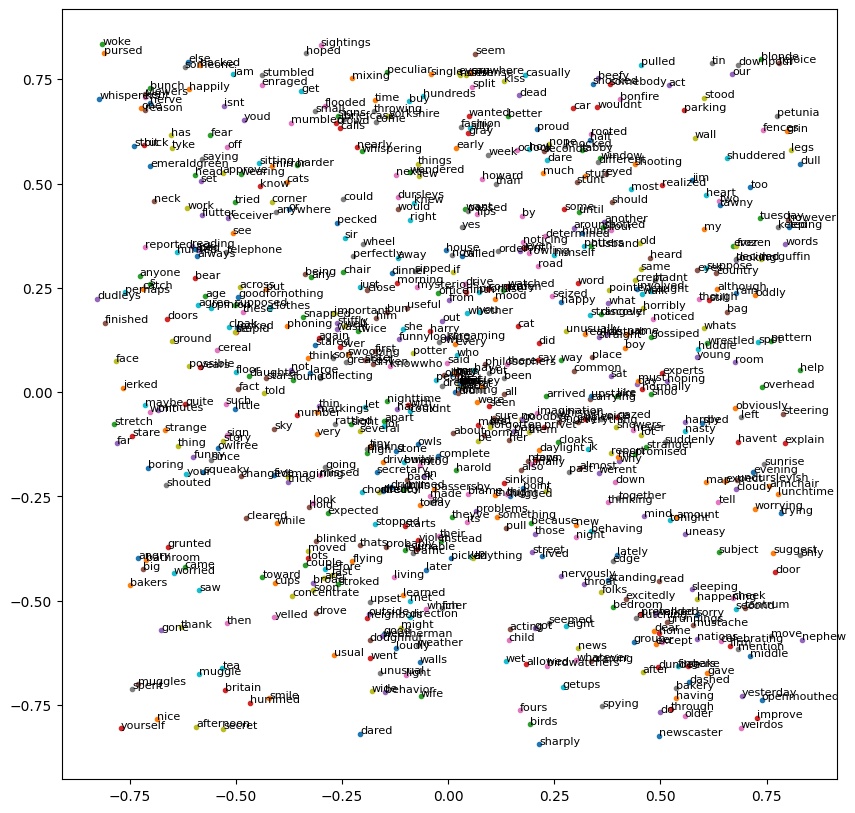

In [ ]:
# Plot the word vectors
plt.figure(figsize=(10, 10))
for i, word in enumerate(word_list):
    vec = W[i]
    plt.scatter(vec[0], vec[1], marker='.')
    plt.annotate(word, xy=(vec[0], vec[1]), fontsize=8)

# Show the plot
plt.show()

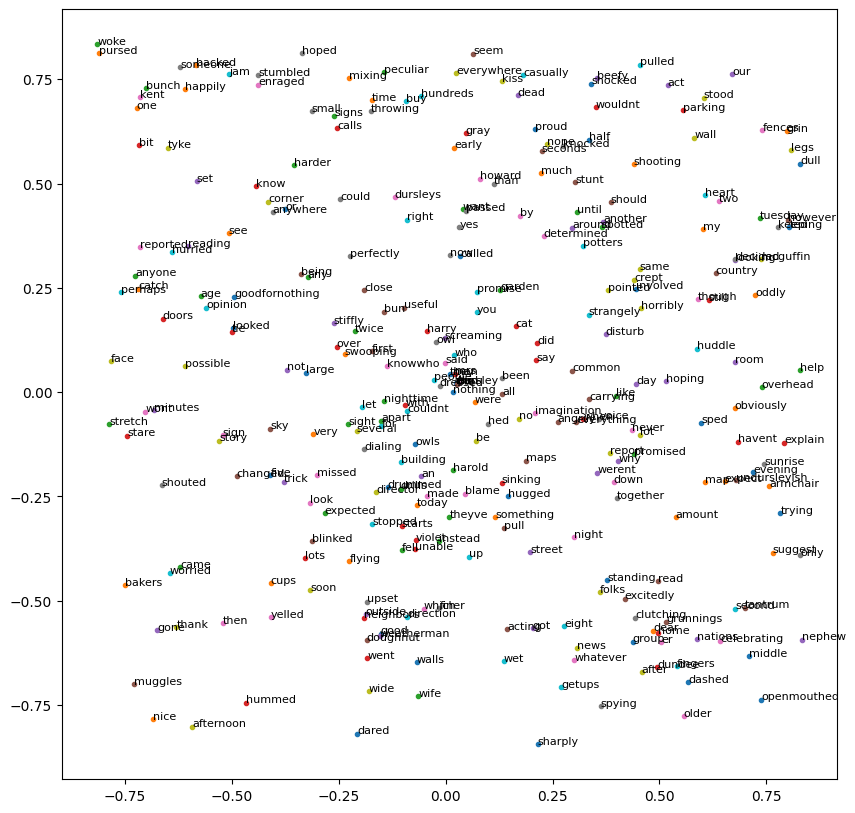

In [ ]:
# Plot the word vectors
plt.figure(figsize=(10, 10))
plot_limit = 300  # Set the maximum number of words to plot
for i, word in enumerate(word_list[:plot_limit]):
    vec = W[i]
    plt.scatter(vec[0], vec[1], marker='.')
    plt.annotate(word, xy=(vec[0], vec[1]), fontsize=8)

# Show the plot
plt.show()


In [ ]:
# Apply moving average filter for smoothing
smoothed_loss_values = [loss_values[0]]
for i in range(1, len(loss_values)):
    smoothed_loss_values.append(smoothing_factor * smoothed_loss_values[i-1] + (1 - smoothing_factor) * loss_values[i])

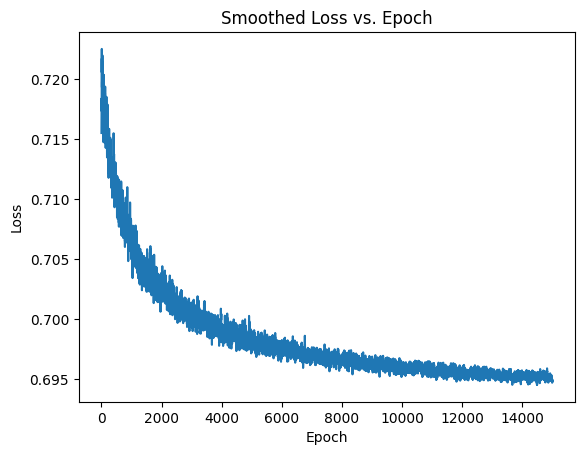

In [ ]:
# Plotting the graph
plt.plot(epochs, smoothed_loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Smoothed Loss vs. Epoch')
plt.show()

In [ ]:
# Save word vectors to a file
np.savetxt("word_vectors.txt", W)